# Class Weight



## 0.환경준비

### (1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

from tqdm import tqdm

# 불필요한 경고 제거
import warnings
warnings.filterwarnings(action='ignore')

### (2) 데이터 로딩

In [ ]:
seed = 28

x, y = make_classification(n_samples=1000,
                        n_features=2,
                        n_redundant=0,
                        weights = [0.95, 0.05],  # class 0과 1의 비율 조정 ==> class imbalance 상황만들기
                        n_clusters_per_class=1,
                        random_state=seed)

In [ ]:
pd.Series(y).value_counts()

0    948
1     52
dtype: int64

In [ ]:
pd.Series(y).value_counts(normalize = True)

0    0.948
1    0.052
dtype: float64

### (3) 필요한 함수 만들기

* 아래 두 함수는 실전에서는 사용하기 곤란합니다. 교육용으로만 사용합니다.^^

* 데이터 분포 시각화 함수

In [ ]:
def my_scatter(x, y) :

    # y가 넘파이 이므로 시리즈로 변환하고 클래스별 갯수 세기
    temp = pd.Series(y).value_counts()

    plt.figure(figsize=(6, 6))
    plt.title(f'0 : {temp[0]},    1 : {temp[1]}')

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)

    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.xlim(-4, 2.2)
    # plt.ylim(-4, 2.2)
    plt.show()

* svm 모델 시각화
    * 아래 모델은 **feauture 수가 2개일 때만 가능**합니다.
    * 모델 두개를 비교 가능.

In [ ]:
def svm_visualize(x, y, model1, model2 = 0) :

    xx, yy = np.meshgrid(np.linspace(x[:,0].min(), x[:,0].max(), 50),
                         np.linspace(x[:,1].min(), x[:,1].max(), 50)) # mesh grid

    # 메쉬 그리드값에 대해 모델 부터 거리 값 만들기.
    Z = model1.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if model2 != 0 : # 두번째 모델이 있으면 처리
        Z1 = model2.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z1 = Z1.reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)
    plt.contour(xx, yy, Z, levels=[0], colors = 'gray',linestyles  = '--')

    if model2 != 0 : # 두번째 모델이 있으면 처리
        plt.contour(xx, yy, Z1, levels=[0], colors = 'r',linestyles  = '--')

    plt.axis("tight")
    plt.show()

- 위에서 만든 데이터 분포를 확인합니다.

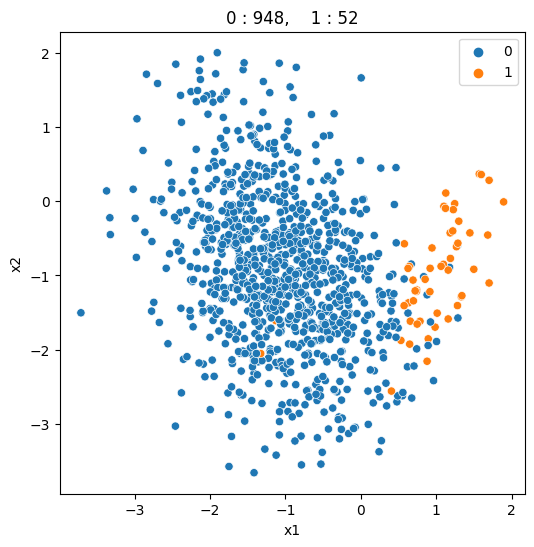

In [ ]:
my_scatter(x, y)

## 1.Class Weight 조정

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import *

### (1) 기본 모델링

In [ ]:
# 모델링 및 평가
model = SVC(kernel='linear')
model.fit(x, y)
pred = model.predict(x)

print(confusion_matrix(y, pred))
print('=' * 55)
print(classification_report(y, pred))

[[940   8]
 [ 19  33]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       948
           1       0.80      0.63      0.71        52

    accuracy                           0.97      1000
   macro avg       0.89      0.81      0.85      1000
weighted avg       0.97      0.97      0.97      1000



### (2) class_weight 조정1
* class_weight='balanced'


In [ ]:
# 모델링 및 평가
model1 = SVC(kernel='linear', class_weight='balanced')
model1.fit(x, y)
pred = model1.predict(x)

print(confusion_matrix(y, pred))
print('=' * 55)
print(classification_report(y, pred))

[[890  58]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.46      0.96      0.62        52

    accuracy                           0.94      1000
   macro avg       0.73      0.95      0.80      1000
weighted avg       0.97      0.94      0.95      1000



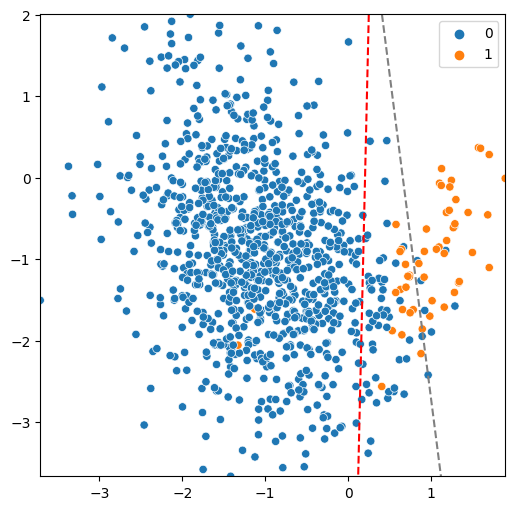

In [ ]:
svm_visualize(x,y, model, model1)

### (3) class_weight 조정2
* class_weight= {0:##, 1:##}


[[798 150]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       948
           1       0.25      0.96      0.40        52

    accuracy                           0.85      1000
   macro avg       0.62      0.90      0.65      1000
weighted avg       0.96      0.85      0.89      1000



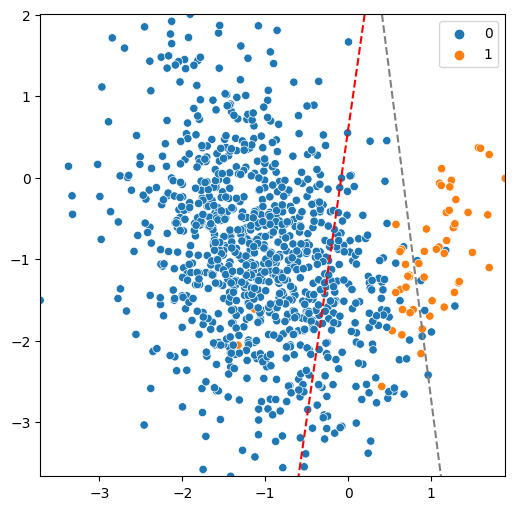

In [ ]:
weight_1 = 0.99
model1 = SVC(kernel='linear', class_weight= { 0:(1-weight_1)  , 1:weight_1} )
model1.fit(x, y)
pred = model1.predict(x)
print(confusion_matrix(y, pred))
print(classification_report(y, pred))
svm_visualize(x,y, model, model1)

## 2.실습 : Semiconductor manufacturing process dataset

![](https://assets.pandaily.com/uploads/2021/10/semiconductor.png)

* 반도체 제조 공정은 시점별로 수많은 센서로부터 정보를 수집하여 공정을 감시합니다.
* 센서정보와 함께 공정간 발생된 불량품에 대한 정보를 저장하였습니다.
* 불량을 예측해 봅시다.

### (1) 데이터 준비

#### 1) Data Loading

In [ ]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


변수 정보
* label : 1 - 불량, 0 - 정상
* v### : 센서값들


In [ ]:
print(data['label'].value_counts()) # 범주별 개수
print(data['label'].value_counts()/data.shape[0]) #범주별 비율

0    1463
1     104
Name: label, dtype: int64
0    0.933631
1    0.066369
Name: label, dtype: float64


#### 2) x, y 로 나누기

In [ ]:
target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

#### 3) 데이터 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state=10)

In [ ]:
x_train.shape, y_train.shape

((1253, 52), (1253,))

### (2) 모델링

In [ ]:
# 필요한 라이브러리, 함수들을 불러옵시다.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import *

from sklearn.model_selection import GridSearchCV

#### 1) Class Weight = 'balanced'

* class weight = 'balanced'로 모델링 및 검증

In [ ]:
model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[178 115]
 [  8  13]]
              precision    recall  f1-score   support

           0       0.96      0.61      0.74       293
           1       0.10      0.62      0.17        21

    accuracy                           0.61       314
   macro avg       0.53      0.61      0.46       314
weighted avg       0.90      0.61      0.71       314



* [참조]여러번 반복시행하여 성능 분포 확인해보기

#### 2) class_weight = 비율로 조절
* Grid Search 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
weights = np.linspace(0, 0.99, 100)
params = { 'class_weight':[{0:x, 1:1-x } for x in weights]}
params

{'class_weight': [{0: 0.0, 1: 1.0},
  {0: 0.01, 1: 0.99},
  {0: 0.02, 1: 0.98},
  {0: 0.03, 1: 0.97},
  {0: 0.04, 1: 0.96},
  {0: 0.05, 1: 0.95},
  {0: 0.06, 1: 0.94},
  {0: 0.07, 1: 0.9299999999999999},
  {0: 0.08, 1: 0.92},
  {0: 0.09, 1: 0.91},
  {0: 0.1, 1: 0.9},
  {0: 0.11, 1: 0.89},
  {0: 0.12, 1: 0.88},
  {0: 0.13, 1: 0.87},
  {0: 0.14, 1: 0.86},
  {0: 0.15, 1: 0.85},
  {0: 0.16, 1: 0.84},
  {0: 0.17, 1: 0.83},
  {0: 0.18, 1: 0.8200000000000001},
  {0: 0.19, 1: 0.81},
  {0: 0.2, 1: 0.8},
  {0: 0.21, 1: 0.79},
  {0: 0.22, 1: 0.78},
  {0: 0.23, 1: 0.77},
  {0: 0.24, 1: 0.76},
  {0: 0.25, 1: 0.75},
  {0: 0.26, 1: 0.74},
  {0: 0.27, 1: 0.73},
  {0: 0.28, 1: 0.72},
  {0: 0.29, 1: 0.71},
  {0: 0.3, 1: 0.7},
  {0: 0.31, 1: 0.69},
  {0: 0.32, 1: 0.6799999999999999},
  {0: 0.33, 1: 0.6699999999999999},
  {0: 0.34, 1: 0.6599999999999999},
  {0: 0.35000000000000003, 1: 0.6499999999999999},
  {0: 0.36, 1: 0.64},
  {0: 0.37, 1: 0.63},
  {0: 0.38, 1: 0.62},
  {0: 0.39, 1: 0.61},
  {0: 0.4, 1:

In [ ]:
model2 = GridSearchCV(LogisticRegression(), params, cv = 5, scoring = 'f1')
model2.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'class_weight': [{0: 0.0, 1: 1.0}, {0: 0.01, 1: 0.99},
                                          {0: 0.02, 1: 0.98},
                                          {0: 0.03, 1: 0.97},
                                          {0: 0.04, 1: 0.96},
                                          {0: 0.05, 1: 0.95},
                                          {0: 0.06, 1: 0.94},
                                          {0: 0.07, 1: 0.9299999999999999},
                                          {0: 0.08, 1: 0.92},
                                          {0: 0.09, 1: 0.91}, {0: 0.1, 1: 0.9},
                                          {0: 0.11, 1: 0.89},
                                          {0: 0.12, 1: 0.88},
                                          {0: 0.13, 1: 0.87},
                                          {0: 0.14, 1: 0.86},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.16, 1: 0.84},
                                          {0: 0.17, 1: 0.83},
                                          {0: 0.18, 1: 0.8200000000000001},
                                          {0: 0.19, 1: 0.81}, {0: 0.2, 1: 0.8},
                                          {0: 0.21, 1: 0.79},
                                          {0: 0.22, 1: 0.78},
                                          {0: 0.23, 1: 0.77},
                                          {0: 0.24, 1: 0.76},
                                          {0: 0.25, 1: 0.75},
                                          {0: 0.26, 1: 0.74},
                                          {0: 0.27, 1: 0.73},
                                          {0: 0.28, 1: 0.72},
                                          {0: 0.29, 1: 0.71}, ...]},
             scoring='f1')

In [ ]:
result = pd.DataFrame(model2.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043562,0.006182,0.011542,0.004319,"{0: 0.0, 1: 1.0}","{'class_weight': {0: 0.0, 1: 1.0}}",0.126866,0.126866,0.126866,0.120301,0.120301,0.124240,0.003216,7
1,0.129589,0.011717,0.011713,0.003155,"{0: 0.01, 1: 0.99}","{'class_weight': {0: 0.01, 1: 0.99}}",0.130769,0.125000,0.123552,0.125984,0.121212,0.125304,0.003170,5
2,0.105543,0.030586,0.008802,0.002402,"{0: 0.02, 1: 0.98}","{'class_weight': {0: 0.02, 1: 0.98}}",0.130268,0.120000,0.124514,0.128514,0.126984,0.126056,0.003569,4
3,0.108254,0.014580,0.012569,0.002067,"{0: 0.03, 1: 0.97}","{'class_weight': {0: 0.03, 1: 0.97}}",0.121457,0.125000,0.126482,0.119149,0.130612,0.124540,0.003986,6
4,0.089890,0.041760,0.006916,0.002555,"{0: 0.04, 1: 0.96}","{'class_weight': {0: 0.04, 1: 0.96}}",0.123077,0.115556,0.130081,0.111111,0.133929,0.122751,0.008556,9


0.94


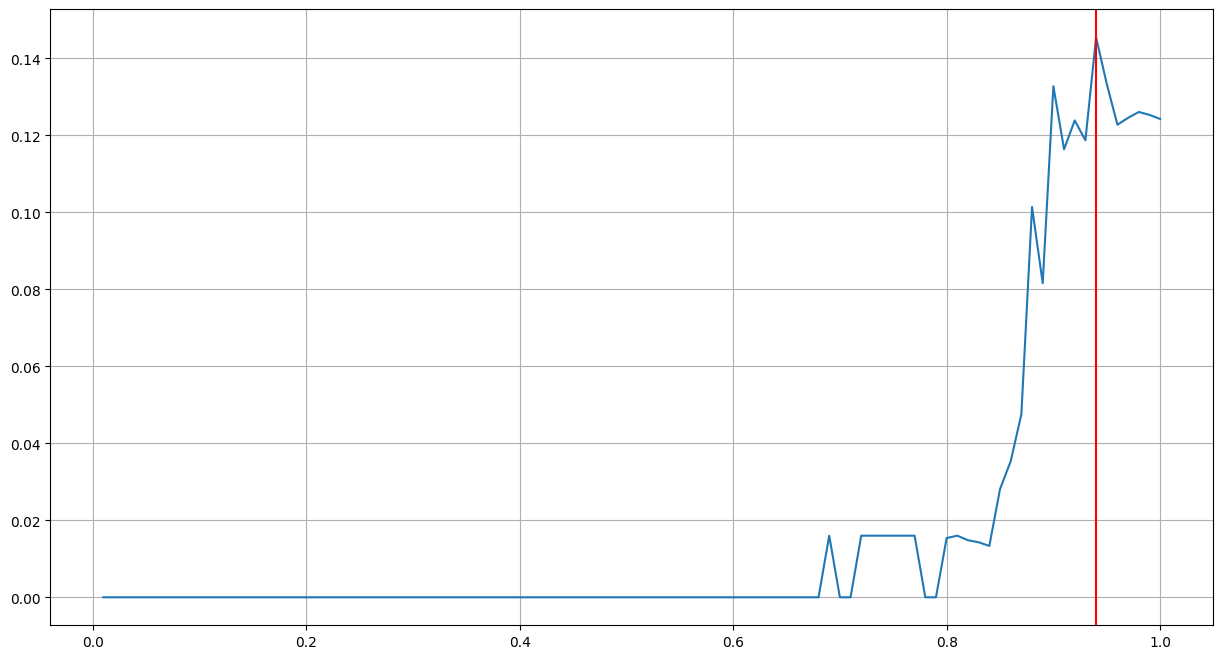

In [ ]:
weight1 = 1- weights
f1 = result['mean_test_score']
best_cw = model2.best_params_['class_weight'][1]

print(best_cw)
plt.figure(figsize = (15,8))
plt.plot(weight1, f1)
plt.axvline(best_cw, color = 'r')
plt.grid()
plt.show()